## **Importing Libraries**

This section loads all essential libraries for:

- **Data Handling**: `pandas`, `numpy`
- **Visualization**: `matplotlib`, `seaborn`, `shap`
- **Machine Learning**: `scikit-learn` for preprocessing, modeling, and evaluation
- **Deep Learning**: `TensorFlow/Keras` for building neural networks
- **Utilities**: `warnings` to suppress unnecessary messages

A clean visual style is applied using `seaborn.whitegrid`.


In [1]:
# SECTION 1 : Importing Libraries

# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

# Suppress warnings for clearer output
warnings.filterwarnings("ignore")

# Scikit-learn modules for data preparation and modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)

# TensorFlow/Keras modules for building neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set Seaborn style for consistent plots
sns.set(style="whitegrid")


###  **Mount Google Drive**

This step connects your Google Drive to the Colab notebook, allowing access to datasets and files stored in Drive.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### **Data Preparation & EDA**

- Loads and cleans the CKD dataset from Google Drive.
- Encodes categorical features and assigns CKD stages based on serum creatinine.
- Splits data for training and testing, then applies feature scaling.
- Visualizes feature distributions using histograms, box plots, and a CKD stage bar chart.


Original dataset shape: (400, 26)
CKD stage distribution:
 ckd_stage
1    208
3     76
5     60
2     39
4     17
Name: count, dtype: int64


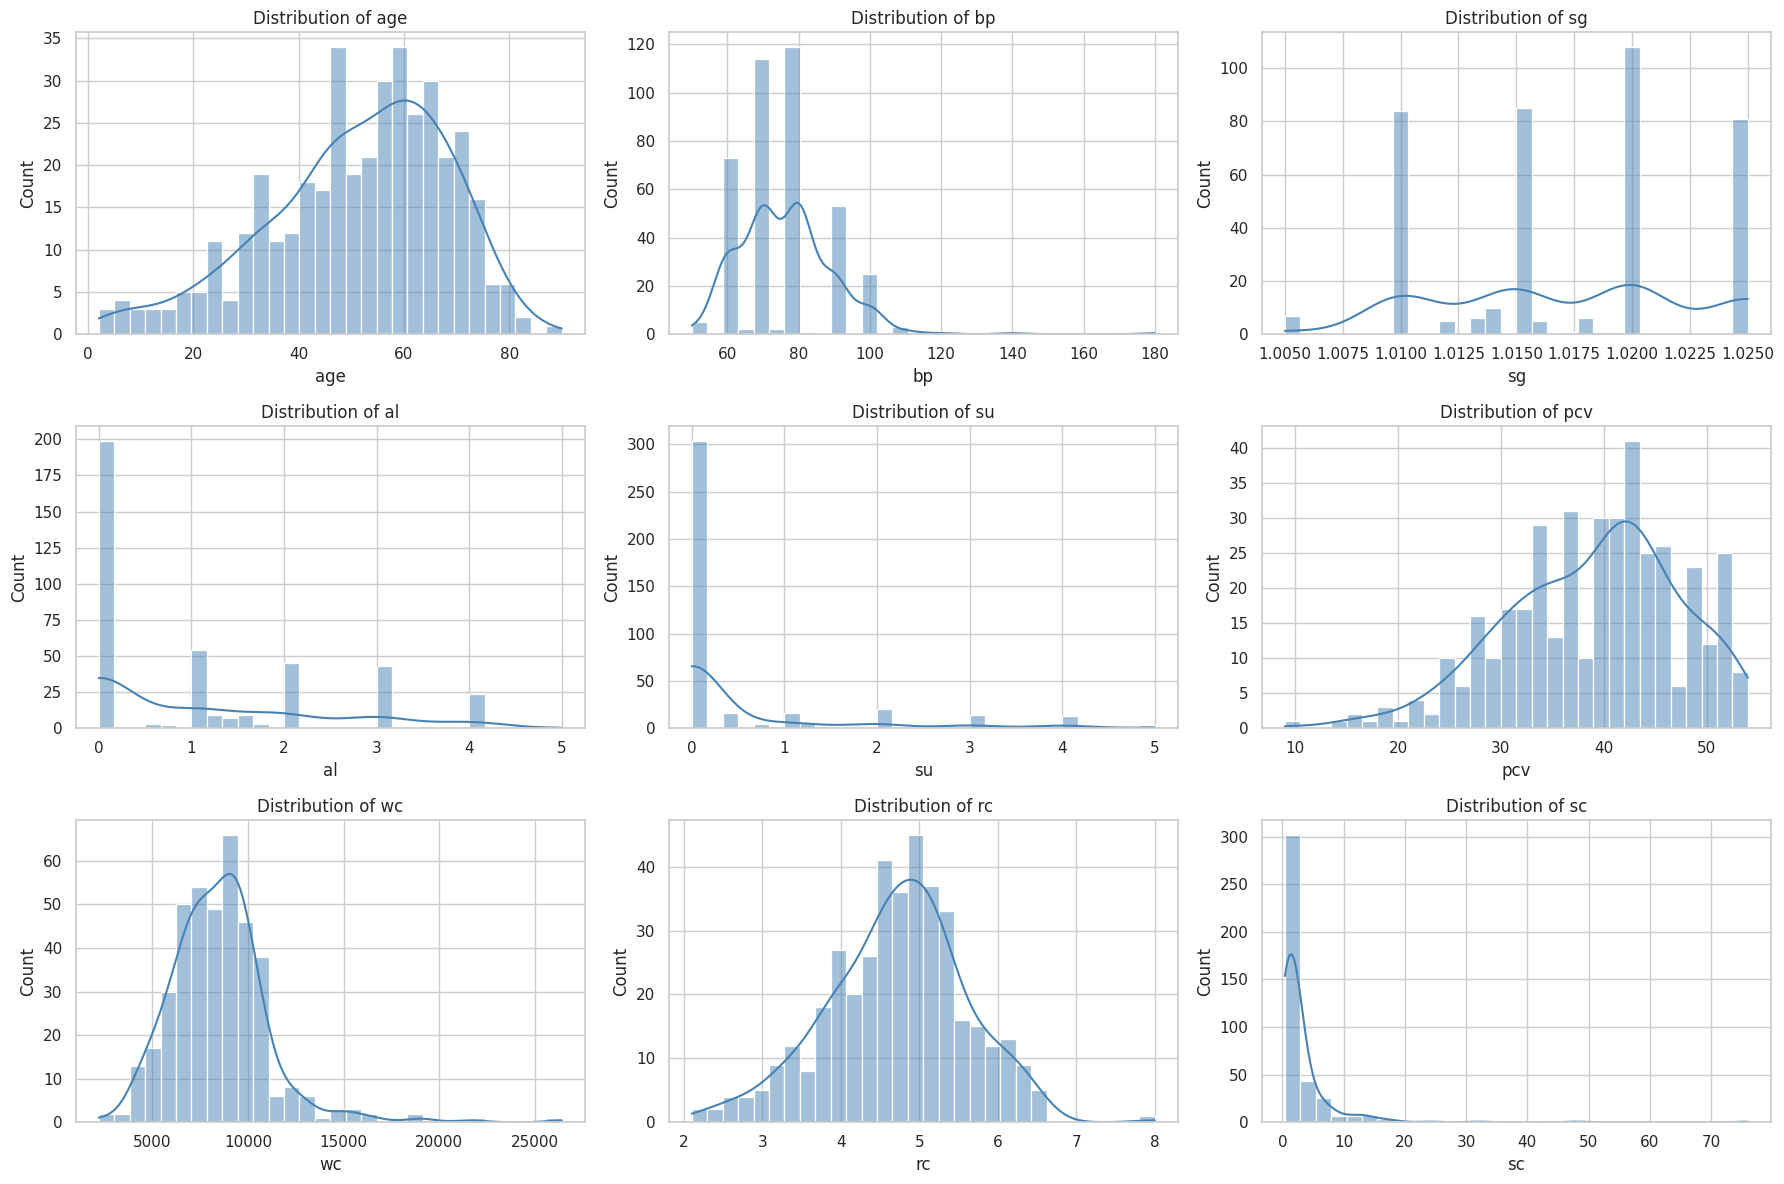

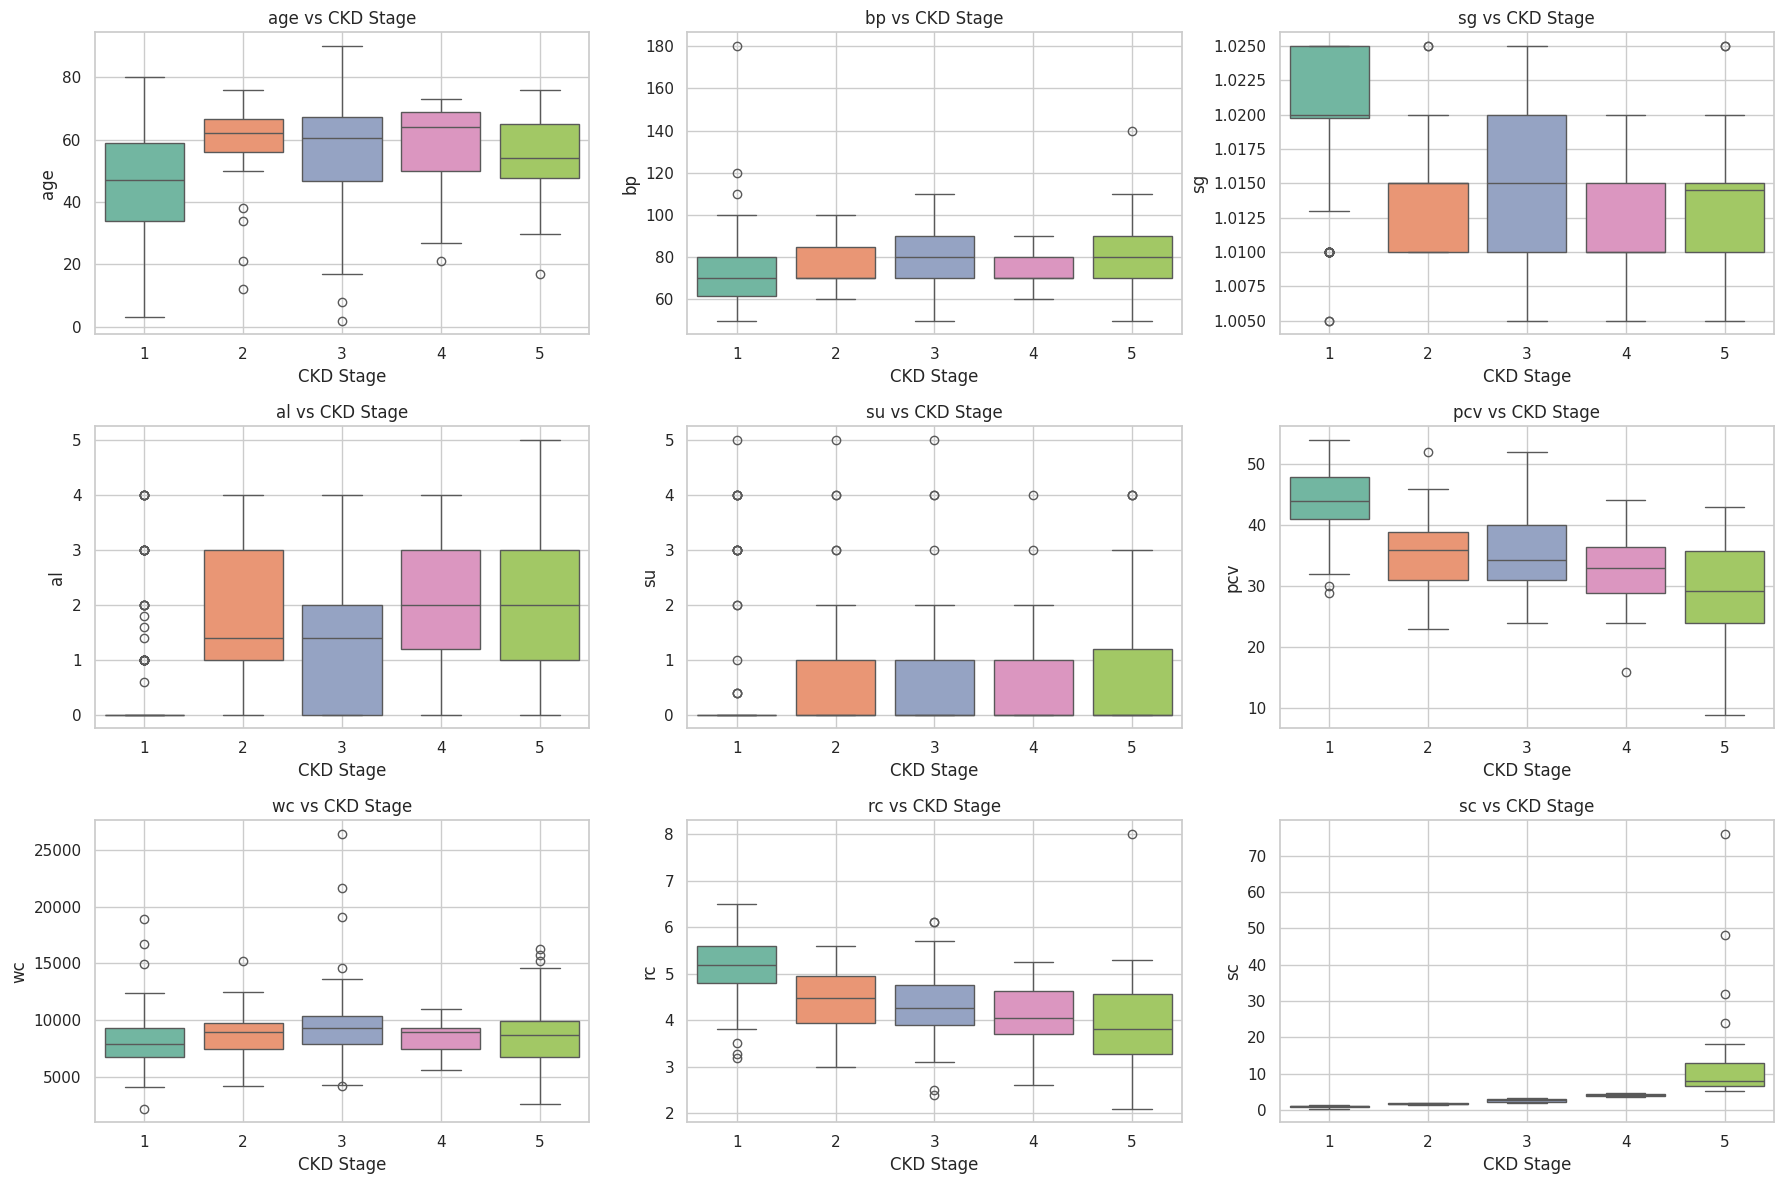

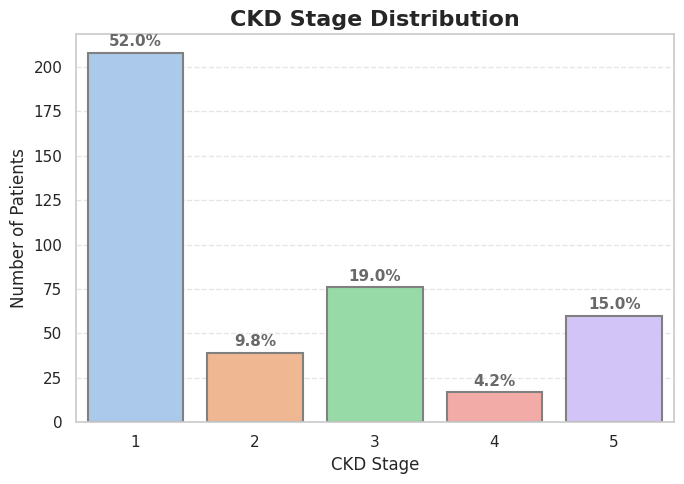

In [3]:
# SECTION 2: Data Preparation & EDA

# Load dataset
file_path = '/content/drive/MyDrive/kidney_disease.csv'
df = pd.read_csv(file_path)
print(f"Original dataset shape: {df.shape}")

# Data Cleaning: Replace invalid entries with NaN
df.replace(to_replace=r'\t\?', value=np.nan, regex=True, inplace=True)
df.replace('?', np.nan, inplace=True)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Convert numeric columns from object to numeric
numeric_columns = ['age', 'bp', 'sg', 'al', 'su', 'pcv', 'wc', 'rc', 'sc']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Encode categorical features using LabelEncoder
categorical_features = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
label_enc = LabelEncoder()
for col in categorical_features:
    df[col] = label_enc.fit_transform(df[col].astype(str))  # convert all to string first to handle NaNs

# Impute missing values using KNN Imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Drop non-numeric / irrelevant columns BEFORE imputation
df_clean = df.drop(columns=['id', 'classification'], errors='ignore')

# Apply KNN Imputer on numeric + encoded categorical data
imputer = KNNImputer(n_neighbors=5)
df_imputed_array = imputer.fit_transform(df_clean)
df_imputed = pd.DataFrame(df_imputed_array, columns=df_clean.columns)


# Define CKD stages based on serum creatinine (sc)
def assign_ckd_stage(sc):
    if sc < 1.5:
        return 1
    elif 1.5 <= sc < 2.0:
        return 2
    elif 2.0 <= sc < 3.5:
        return 3
    elif 3.5 <= sc < 5.0:
        return 4
    else:
        return 5

# Apply CKD stage assignment
df_imputed['ckd_stage'] = df_imputed['sc'].apply(assign_ckd_stage)
print("CKD stage distribution:\n", df_imputed['ckd_stage'].value_counts())

# Encode target variable
y = label_enc.fit_transform(df_imputed['ckd_stage'])

# Drop irrelevant columns and prepare features
X = df_imputed.drop(columns=['id', 'classification', 'ckd_stage'], errors='ignore')

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Feature scaling using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Exploratory Data Analysis (EDA) Plots ---

import matplotlib.pyplot as plt
import seaborn as sns

# Grid of Histograms/KDE plots for numeric columns
num_cols = 3
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(df_imputed[col], kde=True, color='steelblue', bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].grid(True)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Grid of Box Plots: Numeric Features vs CKD Stage
num_cols = 3
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(x='ckd_stage', y=col, data=df_imputed, palette='Set2', ax=axes[i])
    axes[i].set_title(f'{col} vs CKD Stage')
    axes[i].set_xlabel('CKD Stage')
    axes[i].set_ylabel(col)
    axes[i].grid(True)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# CKD stage distribution bar chart with percentages
plt.figure(figsize=(7, 5))
stage_counts = df_imputed['ckd_stage'].value_counts().sort_index()
stage_labels = stage_counts.index
stage_values = stage_counts.values
stage_perc = (stage_values / stage_values.sum()) * 100

sns.barplot(
    x=stage_labels,
    y=stage_values,
    palette='pastel',
    edgecolor='gray',
    linewidth=1.5
)

for i, val in enumerate(stage_values):
    plt.text(i, val + 2, f'{stage_perc[i]:.1f}%', ha='center', va='bottom',
             fontsize=11, fontweight='bold', color='dimgray')

plt.title('CKD Stage Distribution', fontsize=16, fontweight='bold')
plt.xlabel('CKD Stage', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### **Model Training & Hyperparameter Tuning**

This section performs hyperparameter tuning using `GridSearchCV` for:

- **Random Forest**
- **Support Vector Machine (SVM)**
- **Gradient Boosting**

The best parameters are selected based on weighted F1 score, and predictions are made using the optimized models.


In [4]:
# SECTION 3: Hyperparameter Tuning

# Hyperparameter grid for Random Forest
rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV for Random Forest
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1
)
rf_grid.fit(X_train_scaled, y_train)
rf_best = rf_grid.best_estimator_
print("Best Random Forest Parameters:", rf_grid.best_params_)

# Hyperparameter grid for Support Vector Machine (SVM)
svm_params = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# GridSearchCV for SVM
svm_grid = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=svm_params,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1
)
svm_grid.fit(X_train_scaled, y_train)
svm_best = svm_grid.best_estimator_
print("Best SVM Parameters:", svm_grid.best_params_)

# Hyperparameter grid for Gradient Boosting
gb_params = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

# GridSearchCV for Gradient Boosting
gb_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=gb_params,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1
)
gb_grid.fit(X_train_scaled, y_train)
gb_best = gb_grid.best_estimator_
print("Best Gradient Boosting Parameters:", gb_grid.best_params_)

# Predictions on the test set using the best models
rf_pred = rf_best.predict(X_test_scaled)
svm_pred = svm_best.predict(X_test_scaled)
gb_pred = gb_best.predict(X_test_scaled)


Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Gradient Boosting Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


### **Deep Learning Model with Early Stopping**

A simple neural network is built using TensorFlow/Keras to classify CKD stages. Key steps include:

- One-hot encoding of labels for multi-class classification.
- Model architecture with two hidden layers and dropout for regularization.
- Use of `EarlyStopping` to prevent overfitting based on validation loss.
- Training curves for accuracy and loss are plotted to visualize model performance.


Training Deep Neural Network with Class Weights...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.2755 - loss: 1.4814 - val_accuracy: 0.5375 - val_loss: 1.4834
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4261 - loss: 1.5481 - val_accuracy: 0.6000 - val_loss: 1.3026
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4884 - loss: 1.4385 - val_accuracy: 0.6125 - val_loss: 1.1699
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5900 - loss: 1.4222 - val_accuracy: 0.6000 - val_loss: 1.0940
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6139 - loss: 1.1322 - val_accuracy: 0.6125 - val_loss: 1.0225
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6320 - loss: 1.2154 - val_accuracy: 0.6000 - val_loss: 0.9915
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6384 - loss: 1.1820 - val_accuracy: 0.6000 - val_loss: 0.9475
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accura

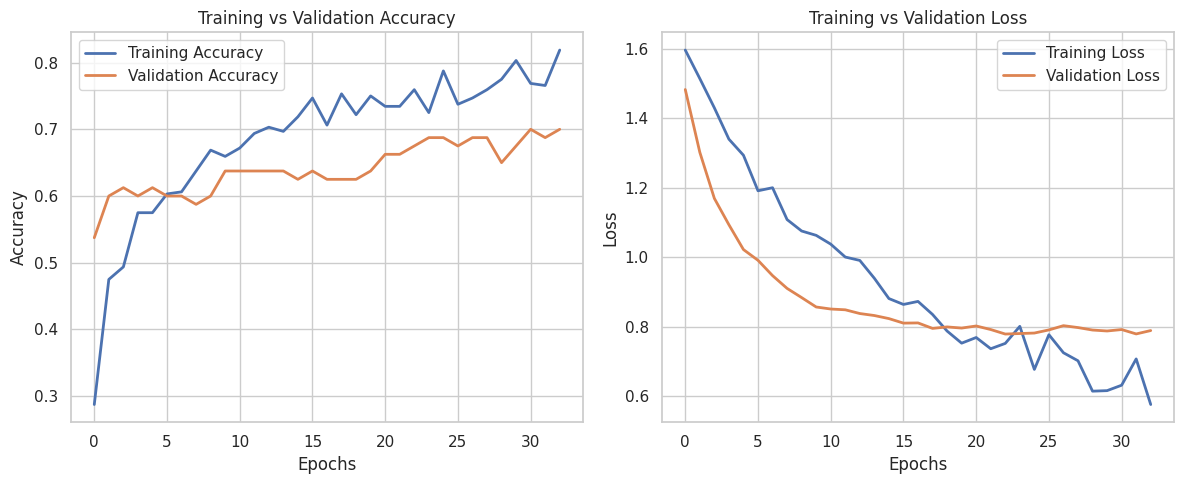

In [5]:
# SECTION 4: Deep Learning with EarlyStopping and Class Weights

print("Training Deep Neural Network with Class Weights...")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# One-hot encode labels for multi-class classification
y_train_cat = to_categorical(y_train, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)

# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Build a lightweight MLP model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 output classes for CKD stages
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Configure EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_test_scaled, y_test_cat),
    epochs=100,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate and make predictions
dl_probs = model.predict(X_test_scaled)
dl_pred = np.argmax(dl_probs, axis=1)

# Plot training accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### **Model Evaluation**

This section evaluates and compares the performance of all trained models:

- Metrics used: **Accuracy**, **F1 Score**, **Precision**, and **Recall**
- Results are summarized in a table and visualized using a bar chart
- Helps identify the best-performing model for CKD stage prediction



 Model Performance Comparison:
                    Model  Accuracy  F1 Score  Precision  Recall
0           Random Forest    0.9125  0.895673   0.896429  0.9125
1  Support Vector Machine    0.7250  0.725917   0.733750  0.7250
2       Gradient Boosting    0.9875  0.987792   0.988889  0.9875
3     Deep Neural Network    0.6750  0.659787   0.656742  0.6750


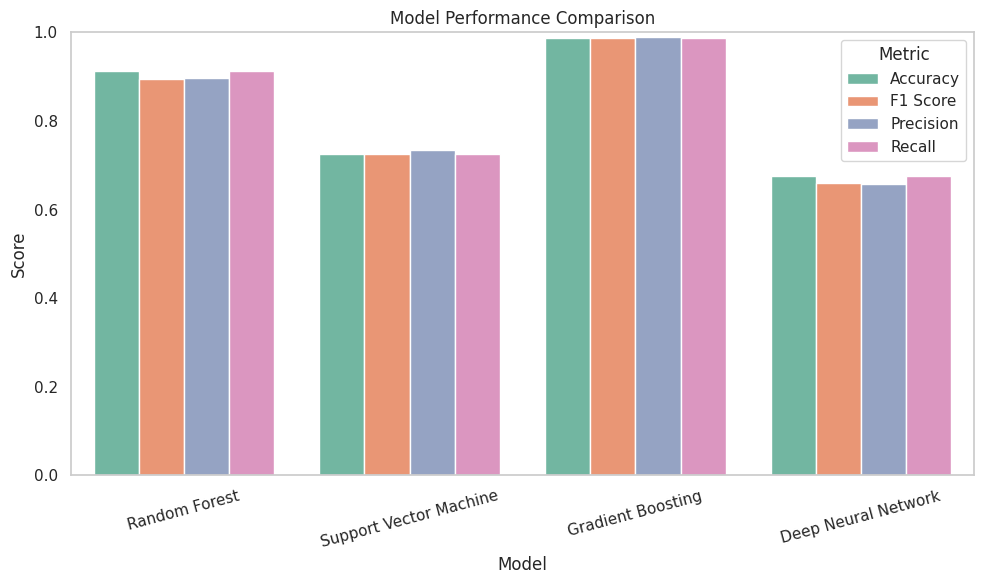

In [6]:
# SECTION 5: Evaluation Metrics

print("\n Model Performance Comparison:")

# Store predictions from all models
model_predictions = {
    "Random Forest": rf_pred,
    "Support Vector Machine": svm_pred,
    "Gradient Boosting": gb_pred,
    "Deep Neural Network": dl_pred
}

# Initialize results list
results = []

# Compute evaluation metrics for each model
for model_name, y_pred in model_predictions.items():
    results.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted')
    })

# Create results dataframe
results_df = pd.DataFrame(results)
print(results_df)

# Plot model performance comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars='Model'),
            x='Model', y='value', hue='variable', palette='Set2')

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.grid(axis='y')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


### **Confusion Matrices**

Displays both raw and normalized confusion matrices for each model to visualize:

- True vs predicted class performance
- Class-wise distribution of correct and incorrect predictions
- Helpful for identifying which CKD stages are most misclassified



 Confusion Matrices (Raw and Normalized):


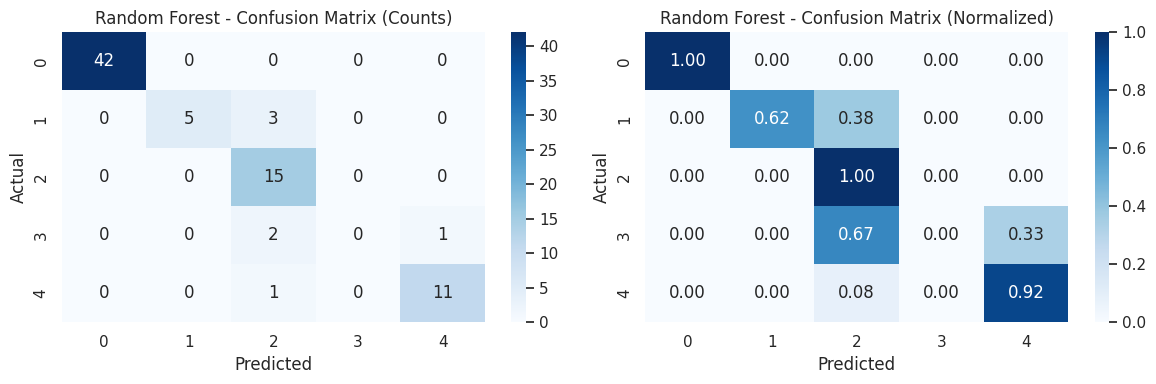

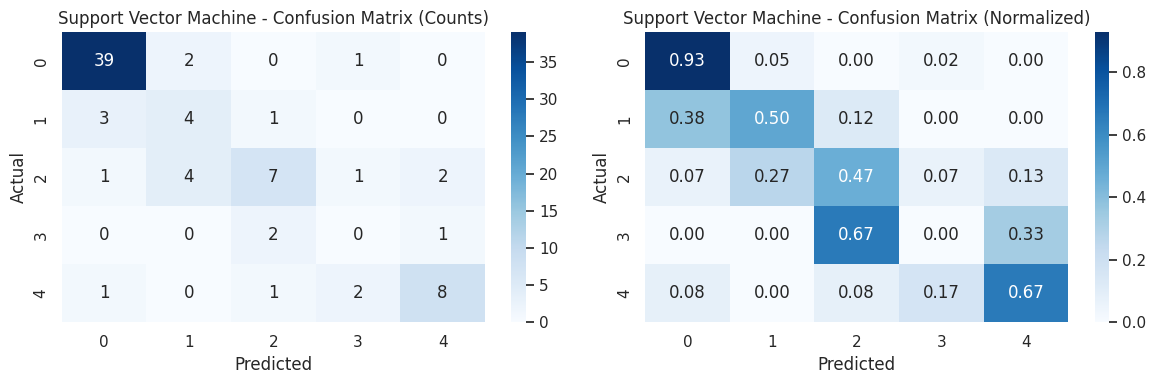

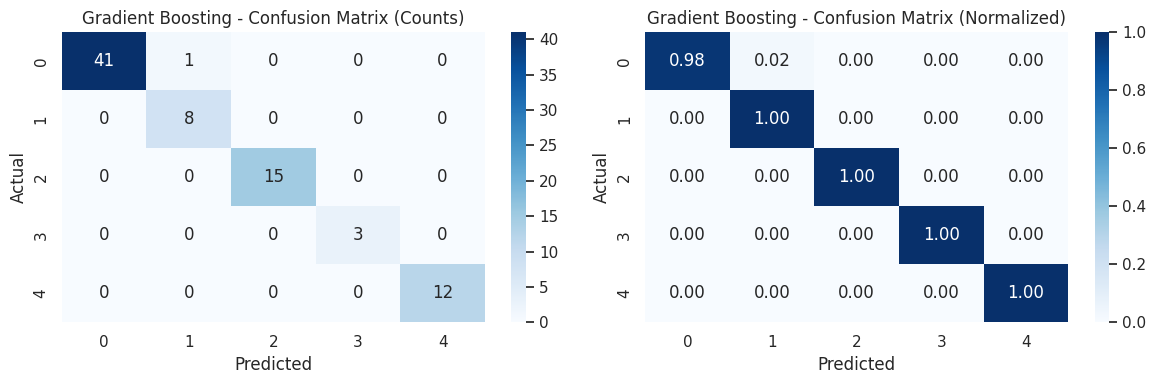

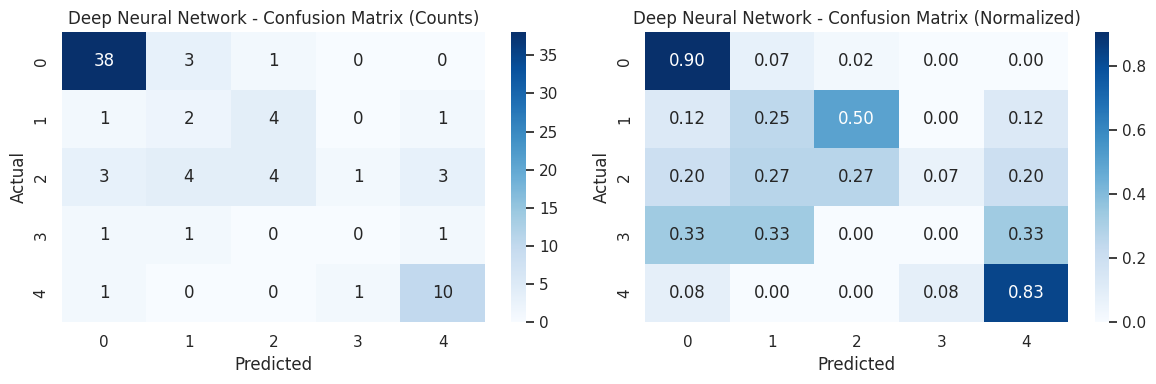

In [7]:
# SECTION 6: Confusion Matrices

print("\n Confusion Matrices (Raw and Normalized):")

# Loop through each model to display its confusion matrix
for model_name, y_pred in model_predictions.items():
    # Raw confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Normalized confusion matrix (row-wise)
    cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

    plt.figure(figsize=(12, 4))

    # Plot raw confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix (Counts)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Plot normalized confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix (Normalized)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()


### **Feature Importances**

Identifies and visualizes the top contributing features from:

- **Random Forest**  
- **Gradient Boosting**

Bar charts display the top 10 most important features, helping interpret model decision-making and understand which clinical indicators most influence CKD stage predictions.



 Feature Importances from Tree-Based Models:

Top Features - Random Forest:
   Feature  Importance
0      sc    0.330642
1      bu    0.157091
2    hemo    0.071039
3     pcv    0.054295
4      al    0.048750
5      rc    0.040889
6     sod    0.033790
7      sg    0.032830
8     age    0.029539
9     pot    0.028072


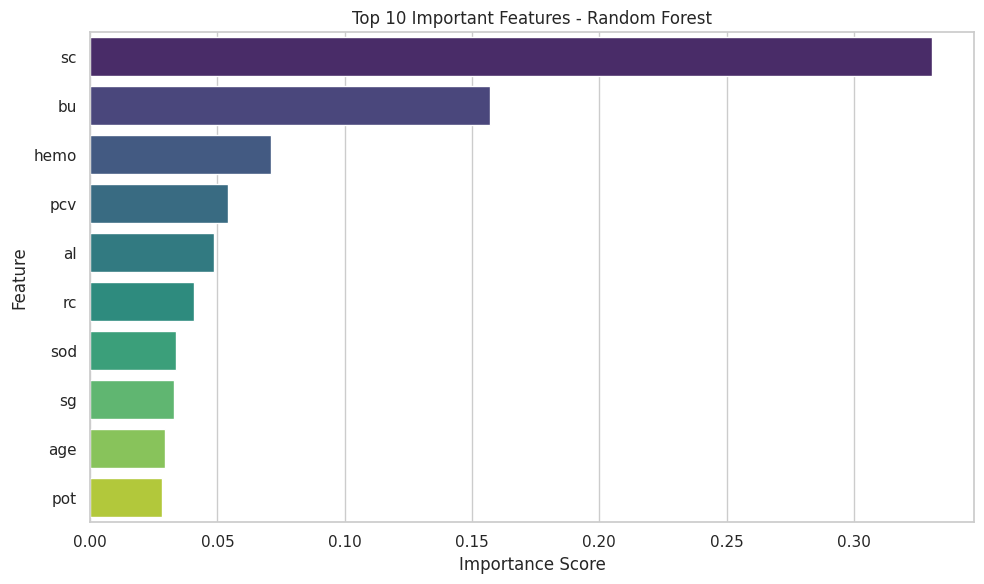


Top Features - Gradient Boosting:
   Feature    Importance
0      sc  1.000000e+00
1      wc  4.401305e-16
2     pot  1.323607e-16
3     bgr  1.146480e-16
4      bu  1.142366e-16
5      rc  1.041656e-16
6     pcv  6.345380e-17
7    hemo  2.514456e-17
8     age  4.813340e-18
9      su  2.369644e-18


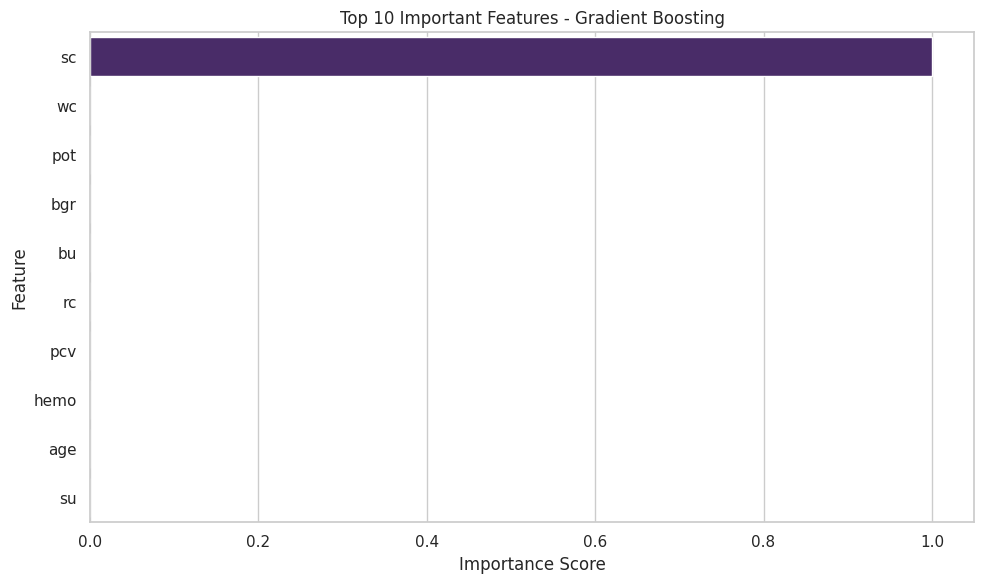

In [8]:
# SECTION 7: Feature Importances

print("\n Feature Importances from Tree-Based Models:")

# Zip model names and model objects
for model_name, model in zip(["Random Forest", "Gradient Boosting"], [rf_best, gb_best]):
    # Ensure the model has feature_importances_ attribute
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        feature_names = X.columns
        indices = np.argsort(importances)[::-1]  # Descending order

        # Create a sorted dataframe for easy viewing
        sorted_features = pd.DataFrame({
            'Feature': feature_names[indices],
            'Importance': importances[indices]
        })

        print(f"\nTop Features - {model_name}:\n", sorted_features.head(10))

        # Plot the feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=sorted_features.head(10), palette='viridis')
        plt.title(f"Top 10 Important Features - {model_name}")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()


### **Model Explainability with SHAP**

SHAP (SHapley Additive exPlanations) is used to interpret feature contributions in the Random Forest model.

- A simplified model is trained for better interpretability.
- SHAP values are aggregated across classes for global importance.
- A bar plot shows the most influential features driving predictions.



SHAP Summary Plot for Random Forest
Combined SHAP shape: (80, 24)
X_test_df shape: (80, 24)


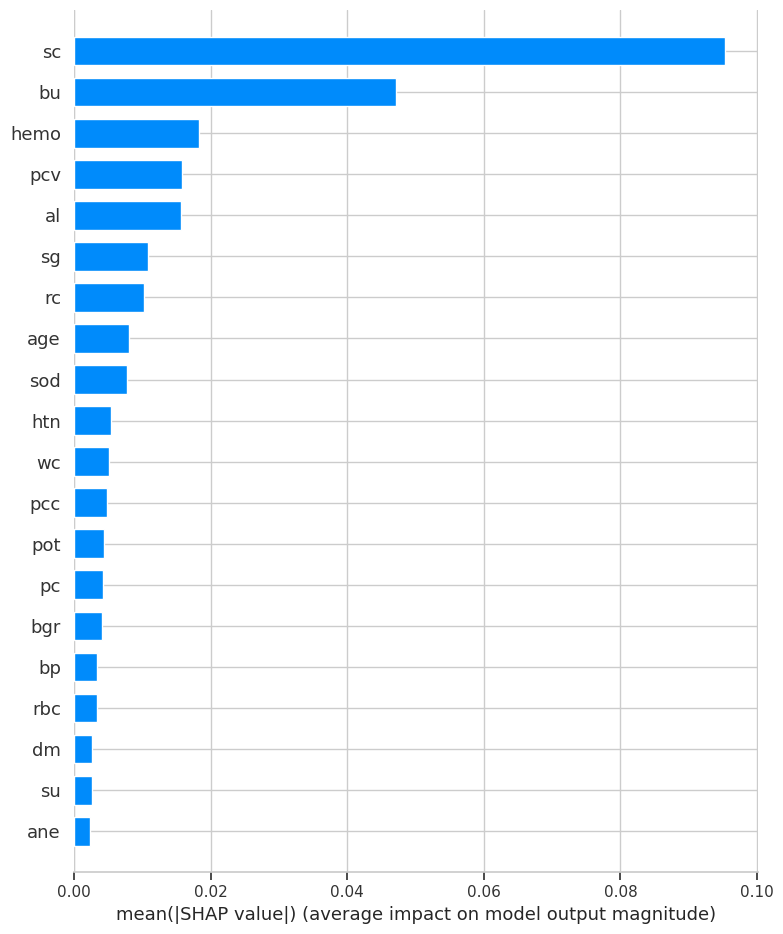

In [9]:
print("\nSHAP Summary Plot for Random Forest")

# Fit a simpler model for interpretability
rf_shap = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_shap.fit(X_train, y_train)

# Create test DataFrame
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# TreeExplainer for multiclass
explainer = shap.TreeExplainer(rf_shap)
shap_values = explainer.shap_values(X_test_df)  # shape: (samples, features, classes)

# Combine across classes
shap_values_combined = np.mean(np.abs(shap_values), axis=2)

# Confirm matching shape
print("Combined SHAP shape:", shap_values_combined.shape)
print("X_test_df shape:", X_test_df.shape)

# Plot summary
shap.summary_plot(shap_values_combined, X_test_df, plot_type='bar')


### **Cross-Validation Scores**

Performs 5-fold cross-validation on the training set to evaluate model stability.

- Reports mean accuracy ± standard deviation
- Helps assess how well each model generalizes to unseen data


In [10]:
# SECTION 9: Cross-Validation Scores

print("\n 5-Fold Cross-Validation Accuracy (on Training Set):")

# Define models and labels
cv_models = {
    "Random Forest": rf_best,
    "Gradient Boosting": gb_best,
    "Support Vector Machine": svm_best
}

# Compute and display mean ± std of accuracy for each model
for model_name, model in cv_models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"{model_name}: {scores.mean():.4f} ± {scores.std():.4f}")



 5-Fold Cross-Validation Accuracy (on Training Set):
Random Forest: 0.9313 ± 0.0212
Gradient Boosting: 1.0000 ± 0.0000
Support Vector Machine: 0.7719 ± 0.0598
